model_name = llama-2-7b-80k_testPPL_64000
   Document Depth  Context Length     Score  \
0            44.0            7513  0.916667   
1            11.0           46590  0.916667   
2            78.0           49846  0.916667   
3            89.0           33564  0.916667   
4            67.0           53103  0.916667   

                                                PPLs  needle_ppl  prefix_ppl  \
0  [17.812448501586914, 9.224867820739746, 71.260...    9.224868   17.812449   
1  [4.926647663116455, 9.070961952209473, 21.3407...    9.070962    4.926648   
2  [7.073549270629883, 8.973233222961426, 49.0772...    8.973233    7.073549   
3  [16.79612922668457, 8.873600959777832, 17.0600...    8.873601   16.796129   
4  [10.689650535583496, 9.0015287399292, 31.25872...    9.001529   10.689651   

   suffix_ppl  
0   71.260162  
1   21.340796  
2   49.077255  
3   17.060047  
4   31.258728  
Overall score 0.905


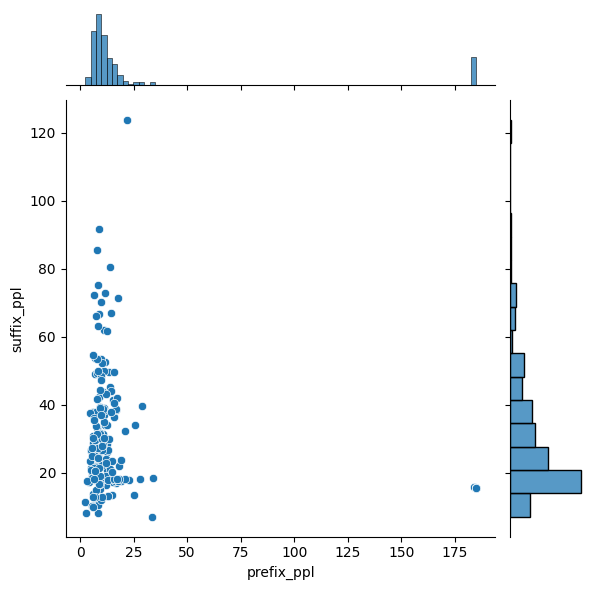

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import glob

FOLDER_PATH = "/vepfs/wcf/G/zecheng/my_repo/Long-Context-Data-Engineering/eval/needle/results/llama-2-7b-80k_testPPL_64000/"
MODEL_NAME = "LLaMA 2 7B continue-trained on 5B tokens 80K length Per-source length upsampled data"
PRETRAINED_LEN=81920

# Path to the directory containing JSON results
folder_path = FOLDER_PATH
if("/" in folder_path):
    model_name = folder_path.split("/")[-2]
else: model_name = MODEL_NAME
print("model_name = %s" % model_name)

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}*.json")

# List to hold the data
data = []
data2 = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        # score = json_data.get("score", None)
        model_response = json_data.get("model_response", None).lower()
        needle = json_data.get("needle", None).lower()
        ppls = json_data.get("ppls", None)
        shift_st, shift_end = json_data.get("shift_st", None), json_data.get("shift_end", None)
        expected_answer = "eat a sandwich and sit in Dolores Park on a sunny day.".lower().split()
        score = len(set(model_response.split()).intersection(set(expected_answer))) / len(expected_answer)
        # Appending to the list
        """
        量化PPLs的变化指标
        1. 前半句话的PPL prefix_ppl
        2. 后半句话的PPL suffix_ppl
        3. 中间needle的PPL needle_ppl
        """
        # bt_ppl_cg = abs(sum(ppls[shift_st-2: shift_st]) - sum(ppls[shift_st: shift_st+2])) / 2
        # end_ppl_cg = abs(sum(ppls[shift_end-2: shift_end]) - sum(ppls[shift_end: shift_end+2])) / 2
        # bt_ins_avg_ppl = sum(ppls[:shift_st]) / shift_st
        # ed_ins_avg_ppl = sum(ppls[shift_end: ]) / shift_end
        data.append({
            "Document Depth": document_depth, "Context Length": context_length,
            "Score": score, "PPLs": ppls, "needle_ppl": ppls[1], 
            "prefix_ppl": ppls[0], "suffix_ppl": ppls[2],
        })


# Creating a DataFrame
df = pd.DataFrame(data)
locations = list(df["Context Length"].unique())
locations.sort()
for li, l in enumerate(locations):
    if(l > PRETRAINED_LEN): break
pretrained_len = li

print(df.head())
print("Overall score %.3f" % df["Score"].mean())

sns.jointplot(x="prefix_ppl", y="suffix_ppl", data=df)

plt.show()

In [11]:
print(df.shape)

print(df[["bt_ins_avg_ppl", "ed_ins_avg_ppl"]])


(200, 6)
     bt_ins_avg_ppl  ed_ins_avg_ppl
0      8.720166e+04       1574.8318
1      3.597508e+03       1238.7556
2      3.980234e+03       1714.5883
3      3.081015e+03      65142.2633
4      6.591226e+03        282.3941
..              ...             ...
195    3.552773e+03      34413.7137
196    1.922698e+03       9597.3545
197    7.865348e+03      20742.2896
198    9.932671e+03       5408.1822
199    3.189650e+07     604347.1192

[200 rows x 2 columns]
